In [14]:
# Imports
import plyvel
import json
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import datetime
import dateutil

In [20]:
# Toggle if plots are stored
STORE_FIGURES = False

In [2]:
# Load data
M01_PATH = './hydra-data/ipns-export-M01'
M02_PATH = './hydra-data/ipns-export-M02'
M03_PATH = './hydra-data/ipns-export-M03'
M04_PATH = './hydra-data/ipns-export-M04'
M05_PATH = './hydra-data/ipns-export-M05'

T01_PATH = './hydra-data/timing-M01.txt'
T02_PATH = './hydra-data/timing-M02.txt'
T03_PATH = './hydra-data/timing-M03.txt'
T04_PATH = './hydra-data/timing-M04.txt'
T05_PATH = './hydra-data/timing-M05.txt'

measurements = []
timings = []

for path in [M01_PATH, M02_PATH, M03_PATH, M04_PATH, M05_PATH]:
    db = plyvel.DB(path)
    try:
        names = {}
        for k, v in db:
            key = k.decode('utf-8')
            # only take versioned entry
            match = re.search('/[0-9]+$', key)
            if match:
                record = json.loads(v)
                record['version'] = int(match.group(0)[1:])
                if not names.get(record['Name']):
                    names[record['Name']] = []
                names[record['Name']].append(record)
        for name in names.keys():
            names[name].sort(key=lambda n: n['version'])
        measurements.append(names)
    finally:
        db.close()

for path in [T01_PATH, T02_PATH, T03_PATH, T04_PATH, T05_PATH]:
    with open(path) as f:
        timings.append(f.read().splitlines())

In [16]:
# Resolve names again
import aioipfs

unresolved_for_measurement = []
async with aioipfs.AsyncIPFS(maddr='/ip4/127.0.0.1/tcp/5001') as client:
    for m in measurements:
        unresolved = 0
        for name in m.keys():
            try:
                x = await client.name.resolve(name=name, dht_timeout='60s')
            except:
                unresolved += 1
        unresolved_for_measurement.append(unresolved)

for i, n in enumerate(unresolved_for_measurement):
    print(f'P{i}: {n} names could not be resolved')

P0: 32 names could not be resolved
P1: 33 names could not be resolved
P2: 3 names could not be resolved


In [17]:
# General statistics

num_names = []
num_received_records = [] # includes records which were received multiple times
num_per_head = []
for m in measurements:
    num_names.append(len(m))
    
    num_received = 0
    for v in m.values():
        num_received += len(v)
    num_received_records.append(num_received)

    names_per_head = {}
    for k in m.keys():
        # only first time received
        if not names_per_head.get(m[k][0]['ReceivingHead']):
            names_per_head[m[k][0]['ReceivingHead']] = 0
        names_per_head[m[k][0]['ReceivingHead']] += 1
    num_per_head.append(names_per_head)


for i, n in enumerate(num_names):
    print(f'P{i}: {n} names')

for i, r in enumerate(num_received_records):
    print(f'P{i}: {r} records')

for i, head_dict in enumerate(num_per_head):
    for h, n in head_dict.items():
        print(f'P{i}: Head {h}: {n} names')



P0: 43 names
P1: 51 names
P2: 10 names
P3: 157 names
P4: 80 names
P0: 176 records
P1: 298 records
P2: 29 records
P3: 5643 records
P4: 471 records
P0: Head 12D3KooWLdeCVR2HubV1dUtPaTYEw4kRxfxqNSjnJuJnSmAevHtN: 9 names
P0: Head 12D3KooWSyVw4rpJT9r33qUSMPKqfcopVEtQbqqnJbaGN6Nn4QUZ: 6 names
P0: Head 12D3KooWMudEfbN4tnBfHYJU4k9f4jZVzF6yeoWN81RToXVnHCxT: 8 names
P0: Head 12D3KooWFCJYprvZH24HTGM2A6mztm93sHmB5Lh49bD2FWoqF6W1: 12 names
P0: Head 12D3KooWQEotLs18UEjmCMwjfVVZGSza1BdDJ6q9WFgs9aJvHrSZ: 8 names
P1: Head 12D3KooWMFQTN5nt94AEN1ARGXLydWLVY46xqRb27p5DaPr6KfXN: 21 names
P1: Head 12D3KooWRQRKBgbi32omNodqkE5VAeSPagNdcCkJCukKNUYgKF2X: 12 names
P1: Head 12D3KooWKCZRGAV93WYJqnbmTbDY79pbCjDVATJkgkgPH7REfgo6: 7 names
P1: Head 12D3KooWJcaqmT6upnyKEwBLU8Qqqc2GA2iTBWFw1sN622E8goPj: 9 names
P1: Head 12D3KooWJfWJ3uT58YRxBHKnKCqZgzZXQP8ADSfv9Nt9RfW6p74t: 2 names
P2: Head 12D3KooWNMgy4Eb4RTc3ocDRQxXte27xfxhs2eJGEQg4ZM8NxKYD: 3 names
P2: Head 12D3KooWKpFHTpBjySKsr2vcoAxvZTkXvuUri5sJHUABWsRsw4gS: 3 names

In [18]:
# Value updates

num_value_updates = []
for m in measurements:
    counts = {}
    for record_updates in m.values():
        previous = None
        for record in record_updates:
            if not previous:
                previous = record
                continue

            if previous['Value'] != record['Value']:
                if not counts.get(record['Name']):
                    counts[record['Name']] = 0
                counts[record['Name']] += 1
                
            previous = record
    num_value_updates.append(counts)

for i, c in enumerate(num_value_updates):
    for n in c.keys():
        print(f'P{i}: {n}: {c[n]} values for same name were updated')


P1: QmS9D6ixtJUpunhVnvrfYkocHUUgcMBVg9mJt9HB3spK4U: 1 values for same name were updated
P3: QmXdA1pRekpjawPLFWvYVs53ckLi6eeK4uuyfWDmktyL9g: 3 values for same name were updated
P3: Qma9r3a7gKM8Lygg8TMV15WomMiQyCufKX9kQ1PPrE1HuD: 1 values for same name were updated
P3: Qmc53pAaYfPPDaPZLPpV8gd46BPjPJE5qsJ2edng4roYSc: 6 values for same name were updated
P3: Qmckqmzv6v3qppgZ6nyxPGQmQjAtr6EAZWBv3JDHRDp67E: 1 values for same name were updated
P4: 12D3KooWEn2aHhf8AA5bfogeCHbaeTwpeKtN31acWzkXjGbPEb5h: 1 values for same name were updated


Max provisions per name:  4661


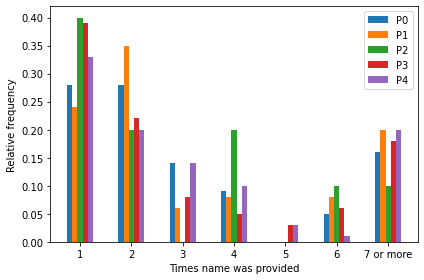

In [21]:
# Number of provisions

max_times = 0
for m in measurements:
    for k in m.keys():
        num_provisions = len(m[k]) - 1
        if num_provisions > max_times:
            max_times = num_provisions

print('Max provisions per name: ', max_times)

labels = [*range(1, 7), '7 or more']
provisions_for_measurements = []

for m in measurements:
    provisions = []
    for _ in range(7):
        provisions.append(0)

    for k in m.keys():
        num_provisions = len(m[k])
        if num_provisions < len(labels):
            provisions[num_provisions - 1] += 1
        else:
            provisions[-1] += 1
    
    provisions_for_measurements.append(provisions)

use_percentages = True

if use_percentages:
    for (i, total) in enumerate(num_names):
        for (j, provisions) in enumerate(provisions_for_measurements[i]):
            provisions_for_measurements[i][j] = round(provisions / total, 2)

x = np.arange(len(labels))
width = 0.1

fig, ax = plt.subplots()
ax.bar(x - 2*width, provisions_for_measurements[0], width, label='P0')
ax.bar(x - width, provisions_for_measurements[1], width, label='P1')
ax.bar(x, provisions_for_measurements[2], width, label='P2')
ax.bar(x + width, provisions_for_measurements[3], width, label='P3')
ax.bar(x + 2*width, provisions_for_measurements[4], width, label='P4')

ax.set_ylabel('Relative frequency')
ax.set_xlabel('Times name was provided')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

if STORE_FIGURES:
    plt.savefig('./pics/provision-times.svg', format='svg')
plt.show()

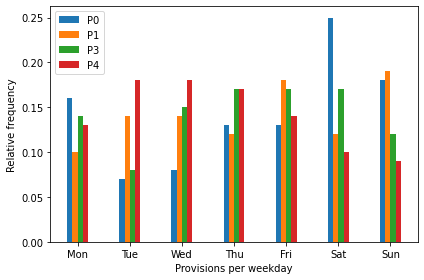

In [22]:
# Provisions per weekday

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
provisions_per_weekday = []
num_records = []

# last one is only over a day
for m in measurements:
    provisions = []
    records = 0
    for _ in range(len(labels)):
        provisions.append(0)

    for record_updates in m.values():
        for record in record_updates:
            d = datetime.datetime.fromisoformat(record['ReceiveTime']).replace(tzinfo=datetime.timezone.utc)
            d -= datetime.timedelta(hours=2)
            provisions[d.weekday()] += 1
            records += 1

    provisions_per_weekday.append(provisions)
    num_records.append(records)

use_percentages = True

if use_percentages:
    for (i, total) in enumerate(num_records):
        for (j, provisions) in enumerate(provisions_per_weekday[i]):
            provisions_per_weekday[i][j] = round(provisions / total, 2)

x = np.arange(len(labels))
width = 0.1

fig, ax = plt.subplots()
ax.bar(x - 3/2 * width, provisions_per_weekday[0], width, label='P0')
ax.bar(x - 1/2 * width, provisions_per_weekday[1], width, label='P1')
ax.bar(x + 1/2 * width, provisions_per_weekday[3], width, label='P3')
ax.bar(x + 3/2 * width, provisions_per_weekday[4], width, label='P4')

ax.set_ylabel('Relative frequency')
ax.set_xlabel('Provisions per weekday')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

if STORE_FIGURES:
    plt.savefig('./pics/provisions-per-weekday.svg', format='svg')
plt.show()

P0: 1 records not resolved
P1: 4 records not resolved
P2: 0 records not resolved
P3: 5103 records not resolved
P4: 367 records not resolved
P0: 1 names not resolved
P1: 2 names not resolved
P2: 0 names not resolved
P3: 145 names not resolved
P4: 72 names not resolved


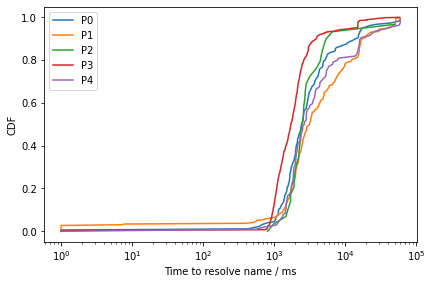

In [23]:
# Access times

accesses_for_measurements = []
steps = []
not_resolved_for_measurements = []
not_resolved_names_for_measurements = []
for m in measurements:
    accesses = []
    not_resolved = 0
    not_resolved_names = {}
    for k in m.keys():
        for record in m[k]:
            if record.get('NameResolveTime'):
                accesses.append(record['NameResolveTime'])
            else:
                not_resolved += 1
                not_resolved_names[k] = True
    accesses_for_measurements.append(np.sort(accesses))
    steps.append(np.array(range(len(accesses)))/float(len(accesses)))
    not_resolved_for_measurements.append(not_resolved)
    not_resolved_names_for_measurements.append(not_resolved_names)

for i, v in enumerate(not_resolved_for_measurements):
    print(f'P{i}: {v} records not resolved')
    
for i, v in enumerate(not_resolved_names_for_measurements):
    print(f'P{i}: {len(v)} names not resolved')

fig, ax = plt.subplots()

ax.plot(accesses_for_measurements[0], steps[0], label='P0')
ax.plot(accesses_for_measurements[1], steps[1], label='P1')
ax.plot(accesses_for_measurements[2], steps[2], label='P2')
ax.plot(accesses_for_measurements[3], steps[3], label='P3')
ax.plot(accesses_for_measurements[4], steps[4], label='P4')

ax.set_ylabel('CDF') # ECDF
ax.set_xlabel('Time to resolve name / ms')
ax.legend()

fig.tight_layout()

plt.xscale('log')

if STORE_FIGURES:
    plt.savefig('./pics/resolution-times.svg', format='svg')
plt.show()


In [24]:
# Expiries

expiries = []

for i, m in enumerate(measurements):
    expired = 0
    not_expired = 0
    end_time_string = timings[i][1]
    end_time = datetime.datetime.fromisoformat(end_time_string)
    for records in m.values():
        validity = dateutil.parser.parse(records[-1]['Validity'])
        if validity < end_time:
            expired += 1
        else:
            not_expired += 1
    expiries.append((expired, not_expired))
        
for i, v in enumerate(expiries):
    print(f'P{i}: {v[0]} expired, {v[1]} not expired')
    print(f'P{i} relative: {round(v[0] / num_names[i], 2)} expired, {round(v[1] / num_names[i], 2)} not expired')          



P0: 23 expired, 20 not expired
P0 relative: 0.53 expired, 0.47 not expired
P1: 34 expired, 17 not expired
P1 relative: 0.67 expired, 0.33 not expired
P2: 0 expired, 10 not expired
P2 relative: 0.0 expired, 1.0 not expired
P3: 97 expired, 60 not expired
P3 relative: 0.62 expired, 0.38 not expired
P4: 52 expired, 28 not expired
P4 relative: 0.65 expired, 0.35 not expired


P0: 0 expired when received
P1: 0 expired when received
P2: 0 expired when received
P3: 0 expired when received
P4: 0 expired when received
Highest validity: 36401.27963563779 days (P3)


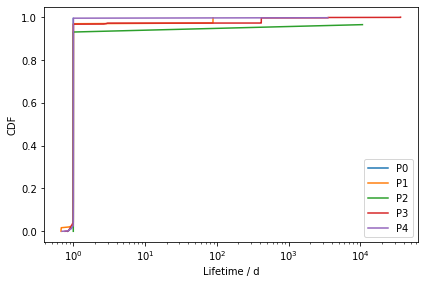

In [25]:
# Lifetimes
lifetimes_for_measurements = []
steps = []
already_expired = []
highest_validity_period = None
highest_validity = 0
for i, m in enumerate(measurements):
    lifetime = []
    expired = 0
    for k in m.keys():
        for record in m[k]:
            received = dateutil.parser.parse(record['ReceiveTime'])
            validity = dateutil.parser.parse(record['Validity'])
            days = (validity - received).total_seconds() / 60 / 60 / 24
            if days > highest_validity:
                highest_validity_period = i
                highest_validity = days
            if days <= 0:
                expired += 1
            lifetime.append(days)
    lifetimes_for_measurements.append(np.sort(lifetime))
    steps.append(np.array(range(len(lifetime)))/float(len(lifetime)))
    already_expired.append(expired)

for i, v in enumerate(already_expired):
    print(f'P{i}: {v} expired when received')

print(f'Highest validity: {highest_validity} days (P{highest_validity_period})')
    
fig, ax = plt.subplots()

ax.plot(lifetimes_for_measurements[0], steps[0], label='P0')
ax.plot(lifetimes_for_measurements[1], steps[1], label='P1')
ax.plot(lifetimes_for_measurements[2], steps[2], label='P2')
ax.plot(lifetimes_for_measurements[3], steps[3], label='P3')
ax.plot(lifetimes_for_measurements[4], steps[4], label='P4')

ax.set_ylabel('CDF') # ECDF
ax.set_xlabel('Lifetime / d')
ax.legend()

fig.tight_layout()

plt.xscale('log')

if STORE_FIGURES:
    plt.savefig('./pics/lifetimes.svg', format='svg')
plt.show()

In [26]:
# Content retrievability

retrievability = []
for m in measurements:
    retrievable = 0
    not_retrievable = 0
    for k in m.keys():
        for record in m[k]:
            if record.get('ContentUnreachable'):
                not_retrievable += 1
            else: 
                retrievable += 1
    retrievability.append((retrievable, not_retrievable))
    
for i, v in enumerate(retrievability):
    print(f'P{i}: {v[0]} retrievable, {v[1]} not retrievable')
    print(f'P{i} relative: {round(v[0] / num_received_records[i], 2)} retrievable, {round(v[1] / num_received_records[i], 2)} not retrievable')

P0: 119 retrievable, 57 not retrievable
P0 relative: 0.68 retrievable, 0.32 not retrievable
P1: 261 retrievable, 37 not retrievable
P1 relative: 0.88 retrievable, 0.12 not retrievable
P2: 25 retrievable, 4 not retrievable
P2 relative: 0.86 retrievable, 0.14 not retrievable
P3: 534 retrievable, 5109 not retrievable
P3 relative: 0.09 retrievable, 0.91 not retrievable
P4: 92 retrievable, 379 not retrievable
P4 relative: 0.2 retrievable, 0.8 not retrievable


In [27]:
# Duplicate names?

duplicates = []
for m in measurements:
    for n in measurements:
        if m != n:
            duplicates += [x for x in m.keys() if x in n.keys()]

print(f'Duplicates: {set(duplicates)}')

for n in set(duplicates):
    for i, m in enumerate(measurements):
        if n in m.keys():
            print(f'{n}: P{i}')

Duplicates: {'12D3KooWBSzKfncXzUeVGkQUCB5WJFyJEc46ugrHzjZDraZ8ZnkL', 'QmR3qRyp4tGF2R5ETGZaRM4aNLGKwYgEHqdccu5hacagDC', '12D3KooWSxCfqm2v914NcEQUVSjUVdXEY3smyawtWnTqmyYnP3EV', '12D3KooWHfJuKZfj35u6rbaExkdQRSka5GX3zDc91CGnGc33QQqb'}
12D3KooWBSzKfncXzUeVGkQUCB5WJFyJEc46ugrHzjZDraZ8ZnkL: P3
12D3KooWBSzKfncXzUeVGkQUCB5WJFyJEc46ugrHzjZDraZ8ZnkL: P4
QmR3qRyp4tGF2R5ETGZaRM4aNLGKwYgEHqdccu5hacagDC: P0
QmR3qRyp4tGF2R5ETGZaRM4aNLGKwYgEHqdccu5hacagDC: P1
QmR3qRyp4tGF2R5ETGZaRM4aNLGKwYgEHqdccu5hacagDC: P3
12D3KooWSxCfqm2v914NcEQUVSjUVdXEY3smyawtWnTqmyYnP3EV: P3
12D3KooWSxCfqm2v914NcEQUVSjUVdXEY3smyawtWnTqmyYnP3EV: P4
12D3KooWHfJuKZfj35u6rbaExkdQRSka5GX3zDc91CGnGc33QQqb: P2
12D3KooWHfJuKZfj35u6rbaExkdQRSka5GX3zDc91CGnGc33QQqb: P4


In [29]:
# Duplicate values?

name_value_pairs = set()
for m in measurements:
    for name in m.keys():
        for record in m[name]:
            name_value_pairs.add((name, record['Value']))

duplicates = []

for a in name_value_pairs:
    for b in name_value_pairs:
        if a != b and a[1] == b[1]:
            duplicates.append(a)
            duplicates.append(b)

# print(f'Duplicates: {duplicates}')
# TODO finalize